In [1]:
library('igraph')
library('Matrix')
library('pracma')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu




In [313]:
facebook_graph <- read_graph('fb_data/facebook_combined.txt', format = 'ncol')

In [4]:
cat("# of vertices:", vcount(facebook_graph), "\n")
cat("# of edges:", ecount(facebook_graph), "\n")
cat("Is connected:", is_connected(facebook_graph), "\n")

# of vertices: 4039 
# of edges: 88234 
Is connected: TRUE 


In [5]:
cat("Graph diameter:", diameter(facebook_graph), "\n")

Graph diameter: 8 


In [6]:
dd = degree_distribution(facebook_graph) * vcount(facebook_graph)
# print(dd)
mu = dot(dd, c(0:(length(dd)-1))) / vcount(facebook_graph)
cat("mean degree:", mu, "\n")

mean degree: 43.69101 


## Core node’s personalized network

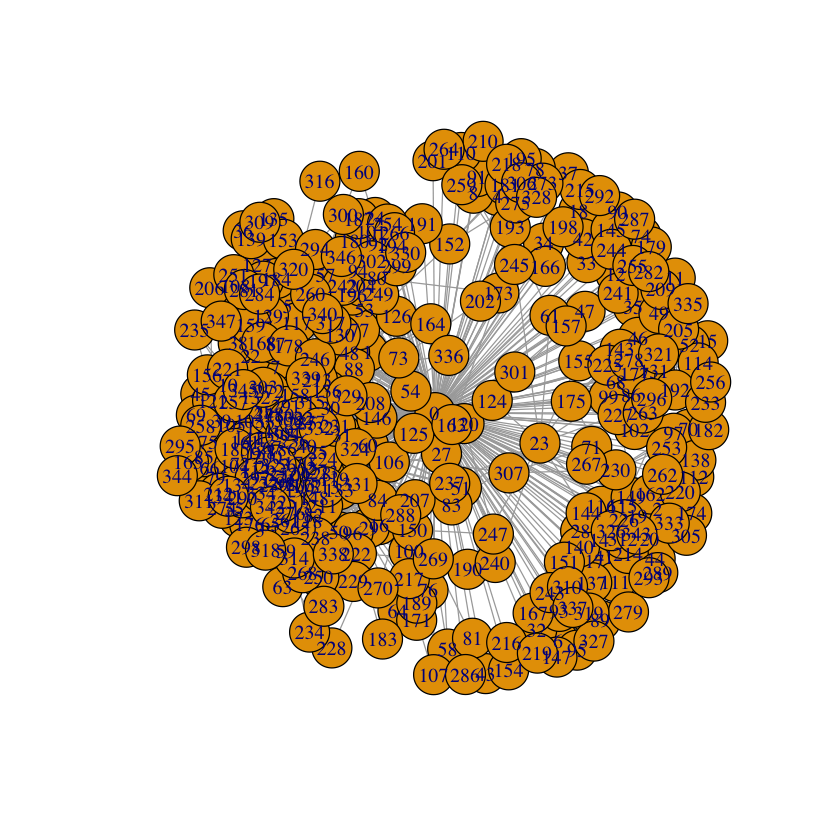

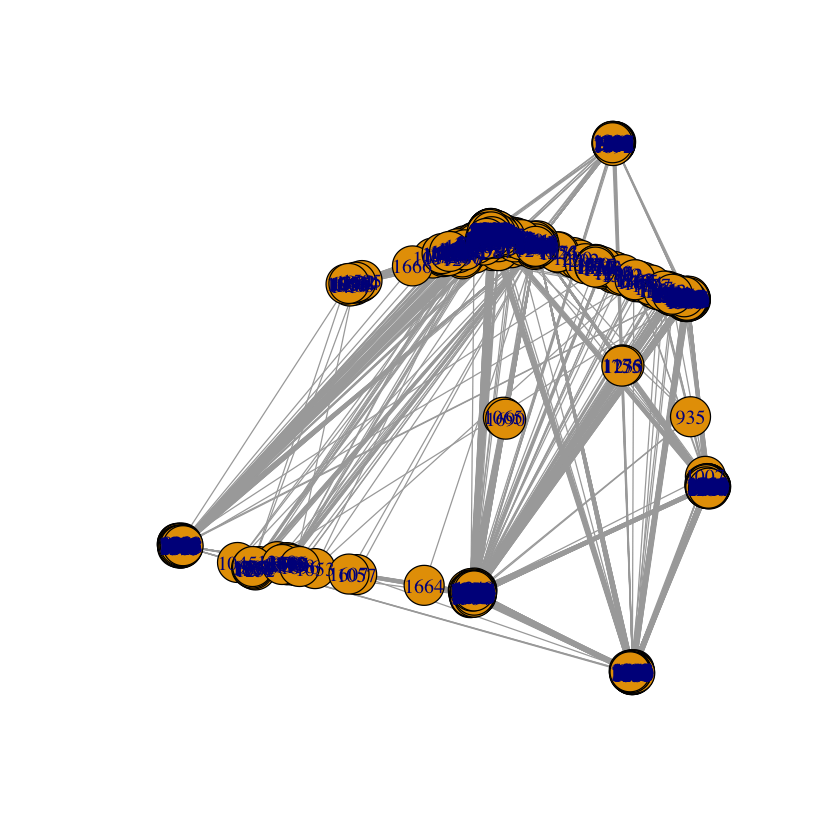

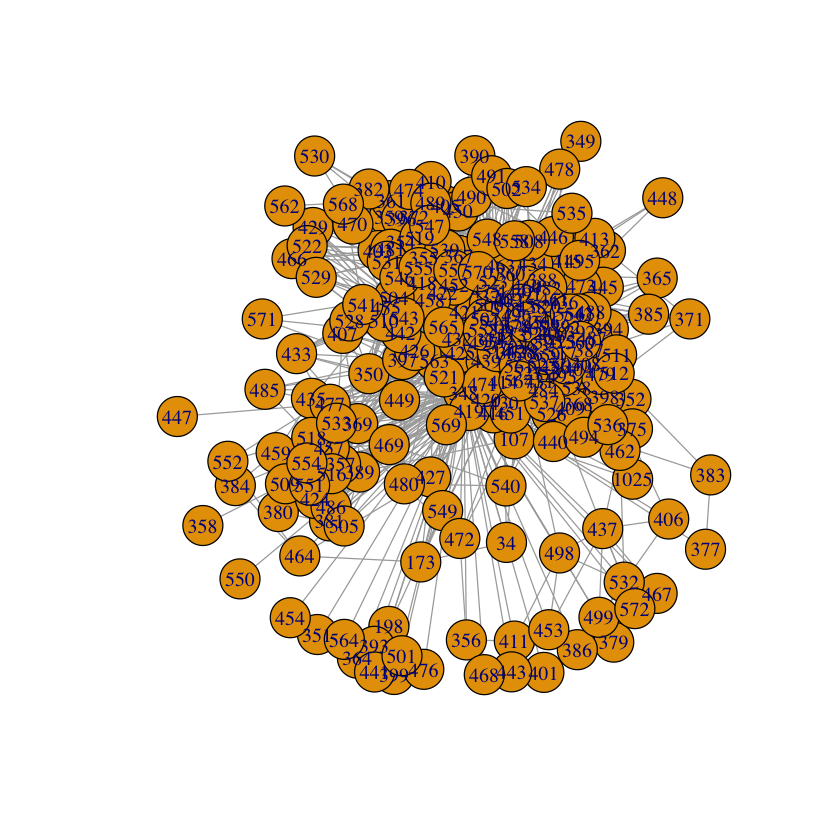

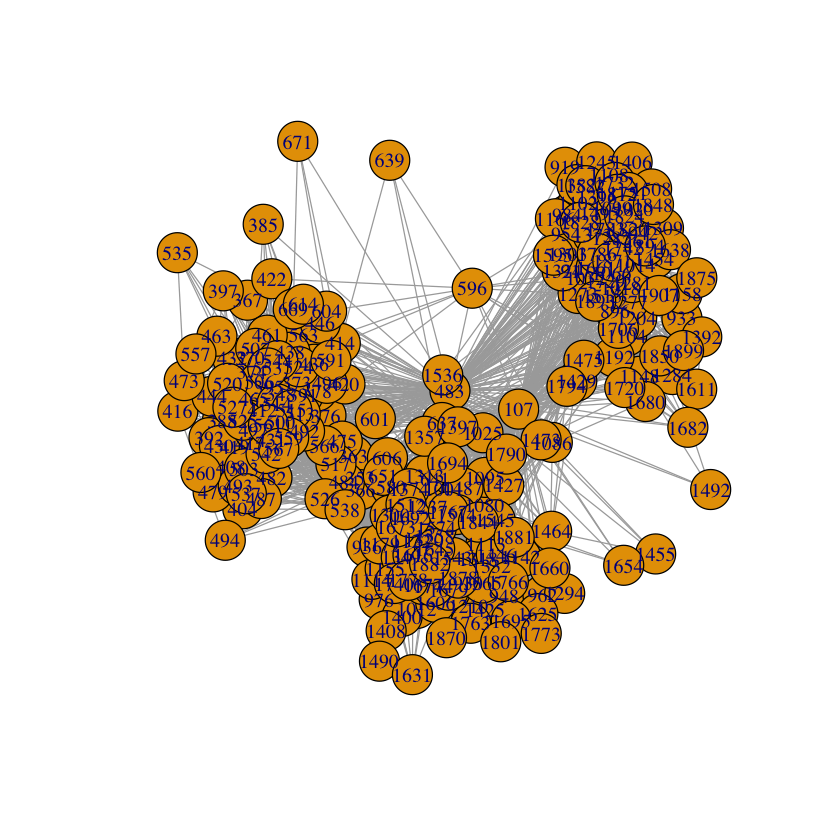

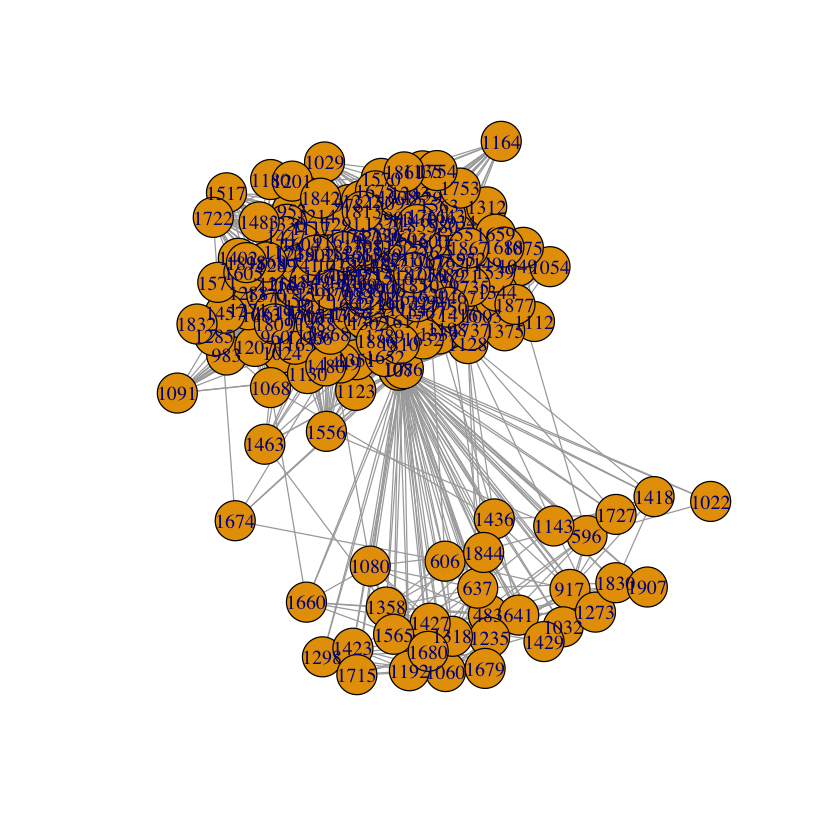

In [341]:
nodes = c("0", "107", "348", "483", "1086")
nodes_len = length(nodes)
personal_list = list(1:nodes_len)
for (i in 1:nodes_len){
    sg <- make_ego_graph(facebook_graph, order = 1, nodes[i])[[1]]
    personal_list[[i]] = sg
#     print(diameter(subgraph1))
    plot(sg)
}



• Embeddedness of a node is defined as the number of mutual friends a node shares with the core node.

• Dispersion of a node is defined as the sum of distances between every pair of the mutual friends the node shares with the core node. The distances should be calculated in a modified graph where the node (whose dispersion is being computed) and the core node are removed.

### QUESTION 12: For each of the core node’s personalized network (use the same core nodes as Question 9), plot the distribution histogram of embeddedness and dispersion. In this question, you will have 10 plots.

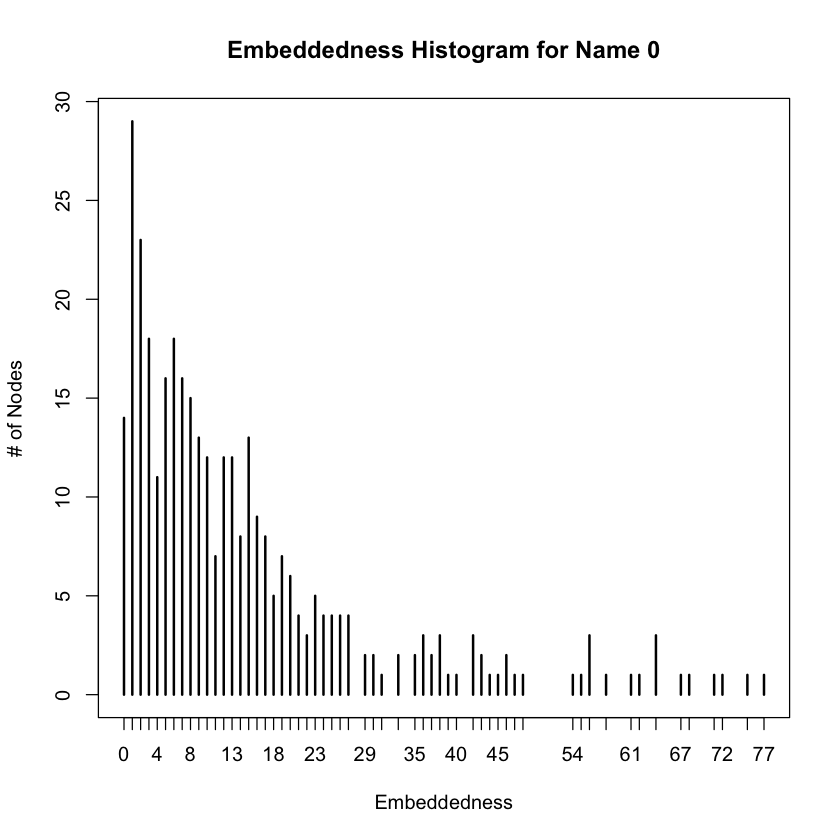

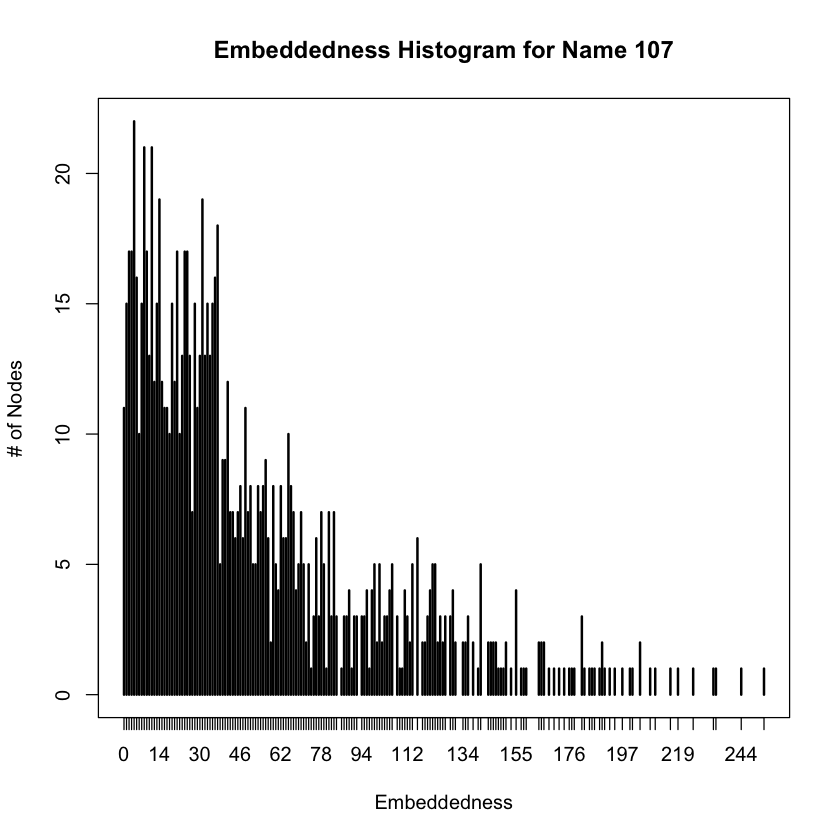

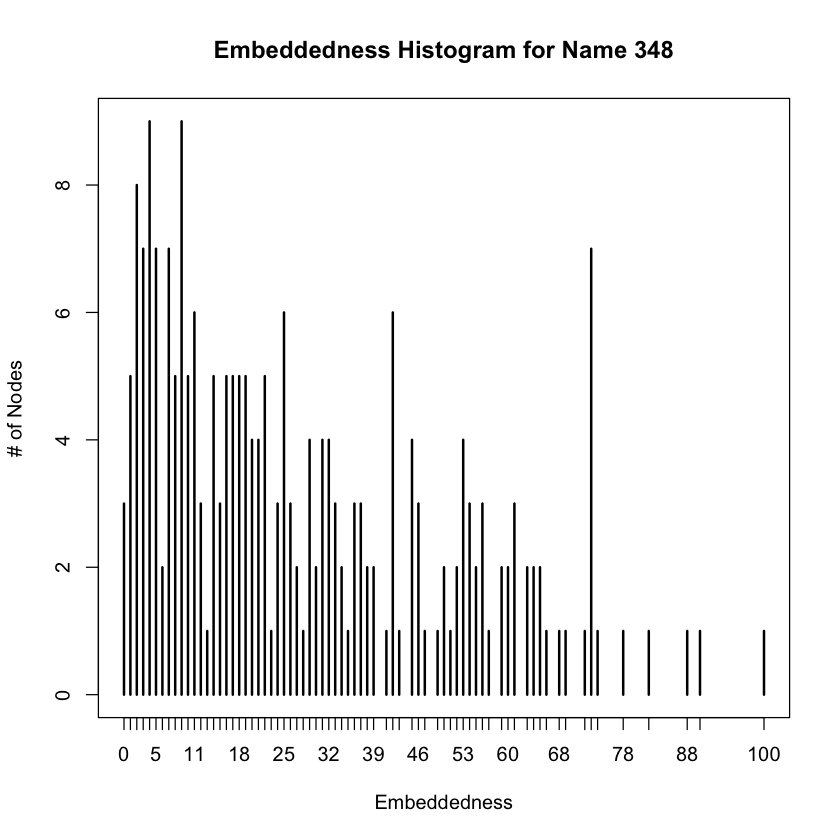

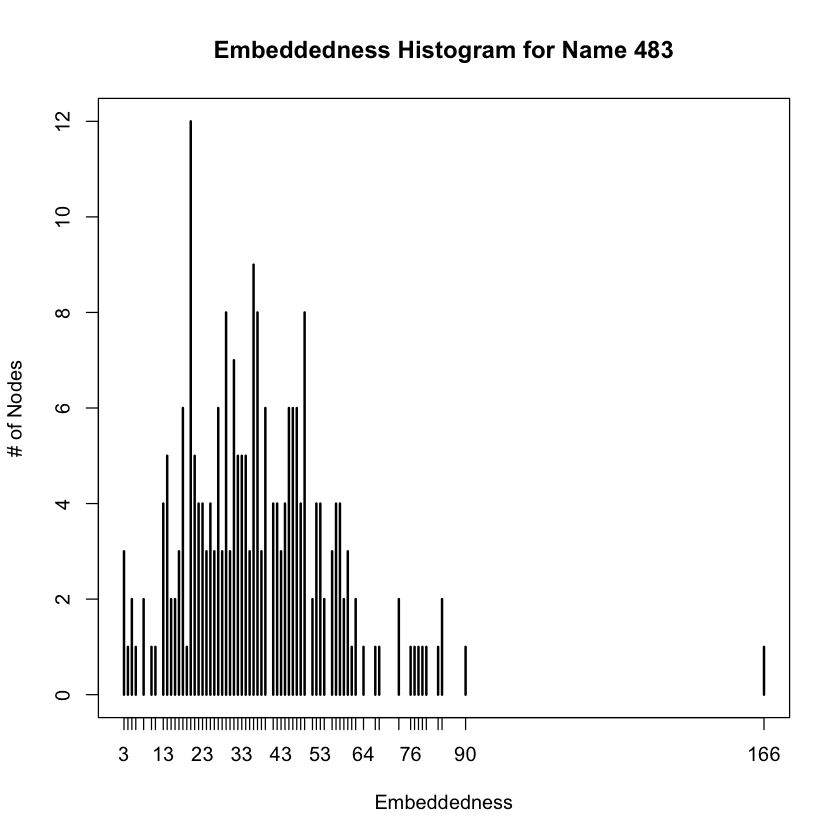

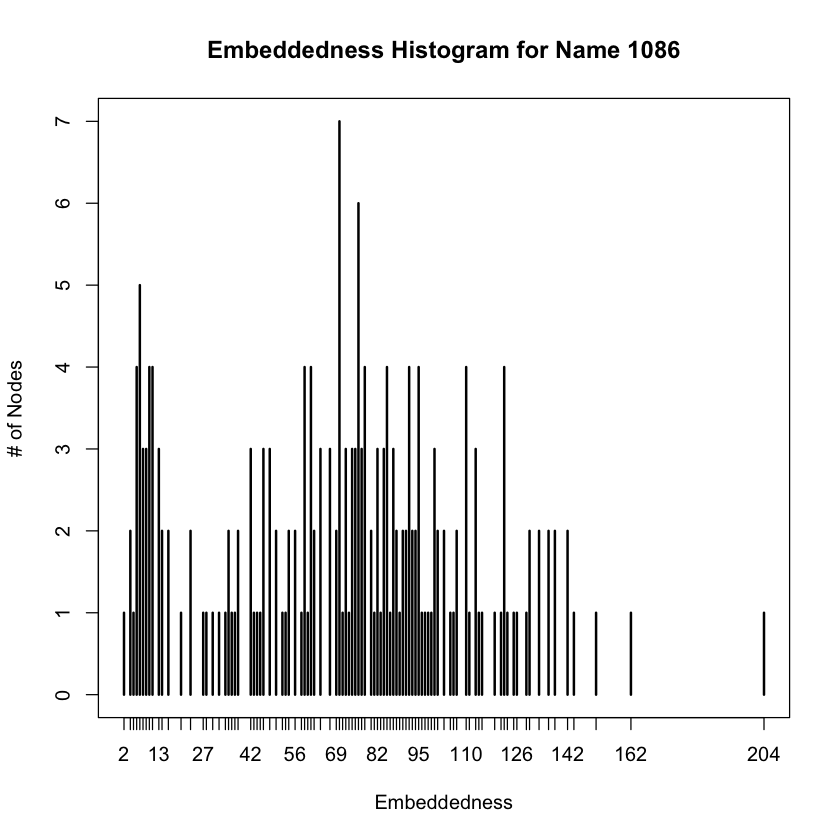

In [323]:
for (i in 1:nodes_len){
#     print(nodes[i])
    pg = personal_list[[i]]
#     print(V(pg))
    neighbor_v = neighbors(pg, nodes[i])
#     print(neighbor_v)
    v_len = length(neighbor_v)
    embd = c(1:v_len)
    for (j in 1:v_len){
#         print(V(personal_list[[i]])[j])
        embd[j] = common_neighbors(pg, nodes[i], neighbor_v[j]$name)
    }
    plot(table(embd), xlab='Embeddedness', ylab='# of Nodes', main=paste0('Embeddedness Histogram for Name ', nodes[i]) )
}

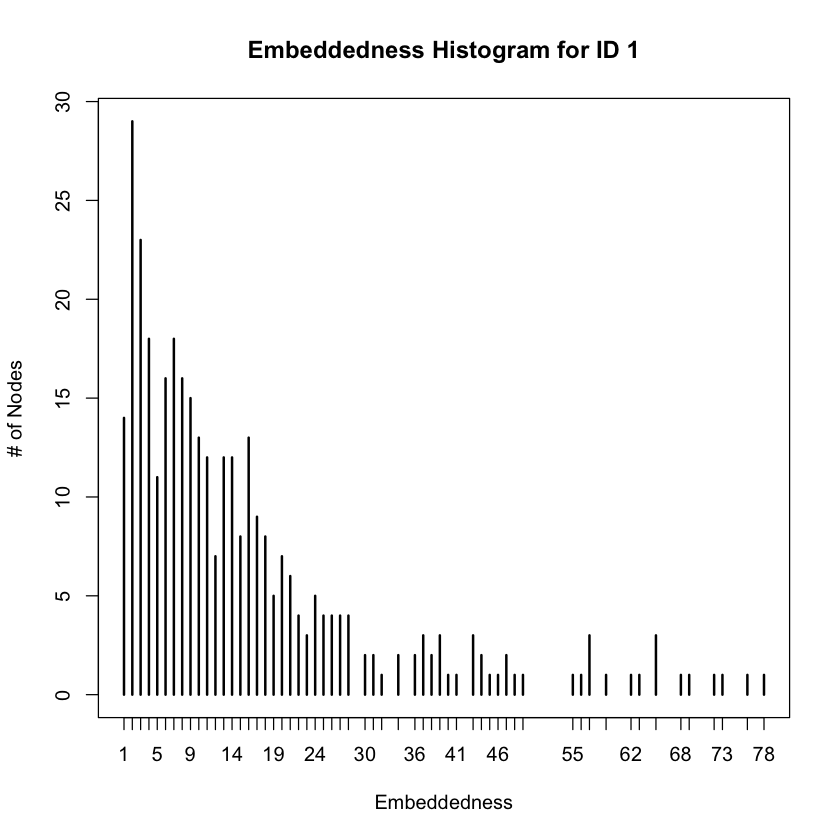

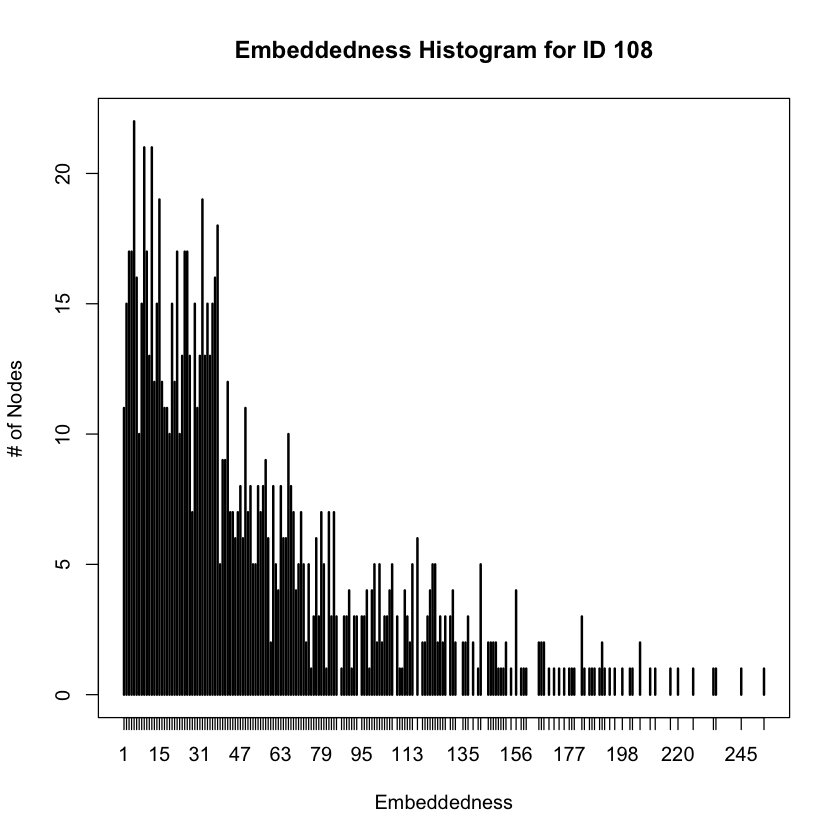

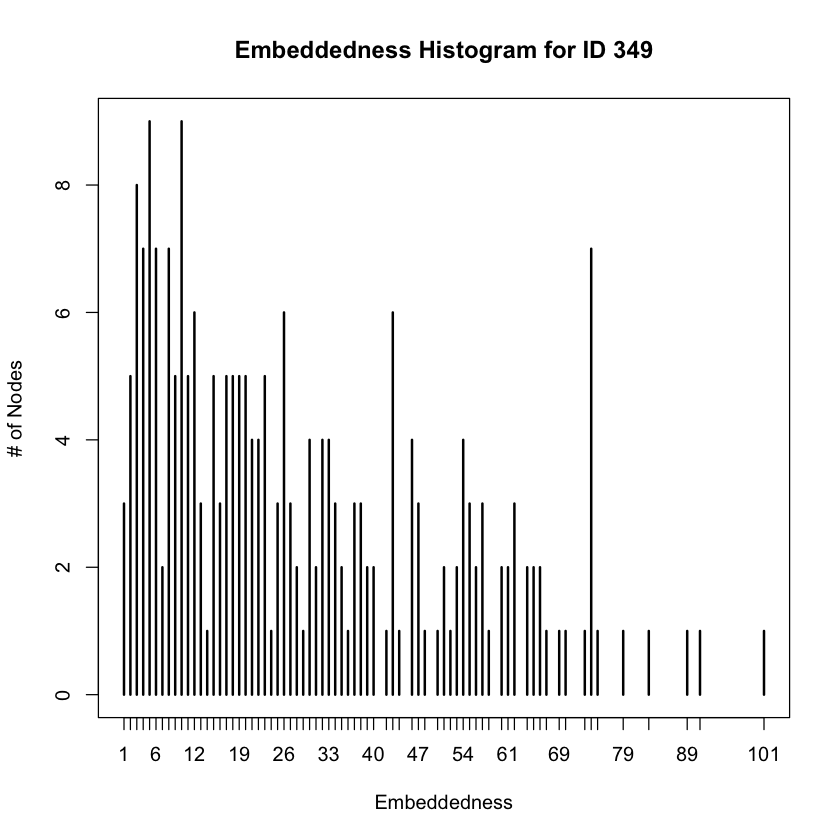

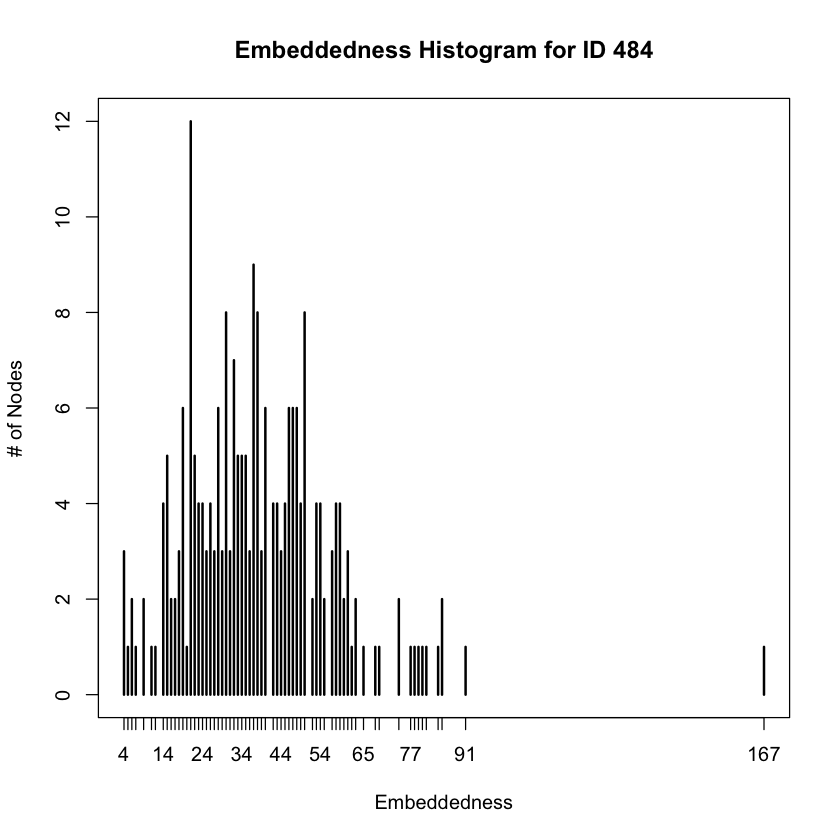

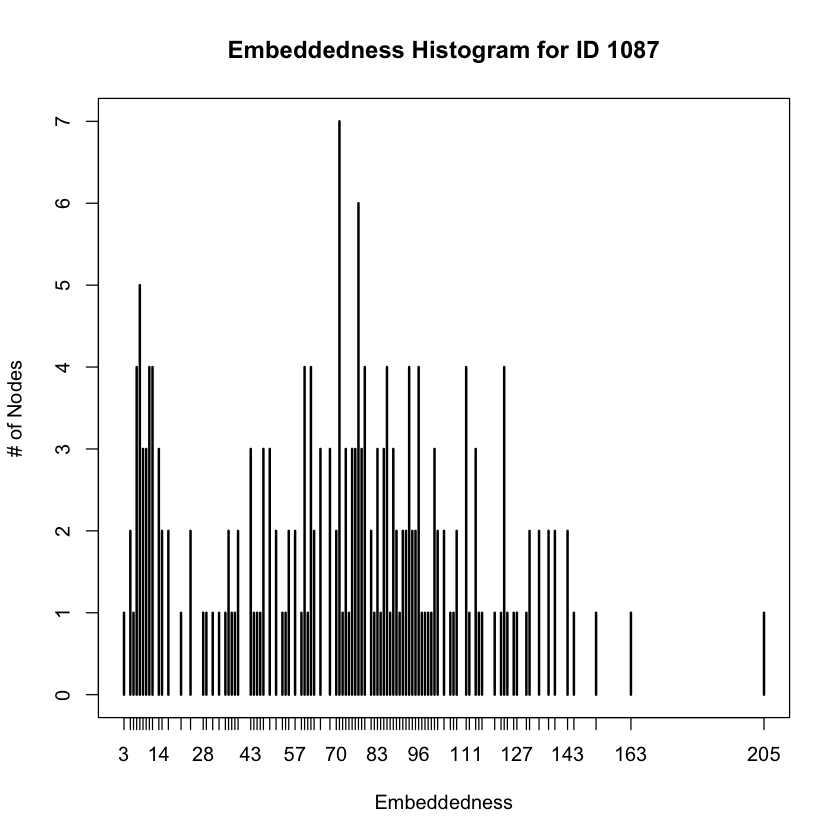

In [365]:
for (i in 1:nodes_len){
#     print(nodes[i])
    pg = personal_list[[i]]
#     print(V(pg))
    neighbor_v = neighbors(pg, nodes[i])
#     print(neighbor_v)
    v_len = length(neighbor_v)
    embd = c(1:v_len)
    for (j in 1:v_len){
        embd[j] = degree(pg, neighbor_v[j]$name)
    }
    plot(table(embd), xlab='Embeddedness', ylab='# of Nodes', main=paste0('Embeddedness Histogram for ID ', strtoi(nodes[i])+1) )
}

In [336]:
find_common_neighbors <- function(graph, node_i, node_j) {
   intersect(neighbors(graph, node_i),neighbors(graph, node_j))
}

find_distance = function (graph, node_i, node_j, upper_bound=10)
{
    distance = distances(graph, node_i, node_j)
    if (distance == Inf) # Set Inf case as diameter + constant 
    {
        distance = 10
    }
    return (distance)
}

In [352]:
# Dispersion
dispersions = list()
for (i in 1:nodes_len){
    # Current personalized network
    pg = personal_list[[i]]
    neighbor_v = neighbors(pg, nodes[i])
    v_len = length(neighbor_v)
    dispersion = c(1:v_len)*0 # Initialize dispersion
    
    for (j in 1:v_len){
        # Find common neighbors
        cn = find_common_neighbors(pg, nodes[i], neighbor_v[j]$name)
        if (length(cn) <= 1) # No pair
        {
            dispersion[j] = 0
        }
        else
        {
            cn = V(pg)$name[cn] # Convert node idx to node names
            pruned_pg = delete.vertices(pg, c(nodes[i], neighbor_v[j]$name)) # Delete core node and current node
            neighbor_comb = combn(cn, 2) # All pair combinations
            for (k in 1:(length(neighbor_comb) / 2))
            {
                node_i_name = neighbor_comb[1, k]
                node_j_name = neighbor_comb[2, k]
                
                dispersion[j] = dispersion[j] + find_distance(pruned_pg, node_i_name, node_j_name)
            }
        }    
    }
    dispersions[[length(dispersions) + 1]] = dispersion # Store the current dispersion
}

In [354]:
# Save dispersions
saveRDS(dispersions, file="dispersions.rds")
# Read dispersions
# dispersions = readRDS(file="dispersions.rds")

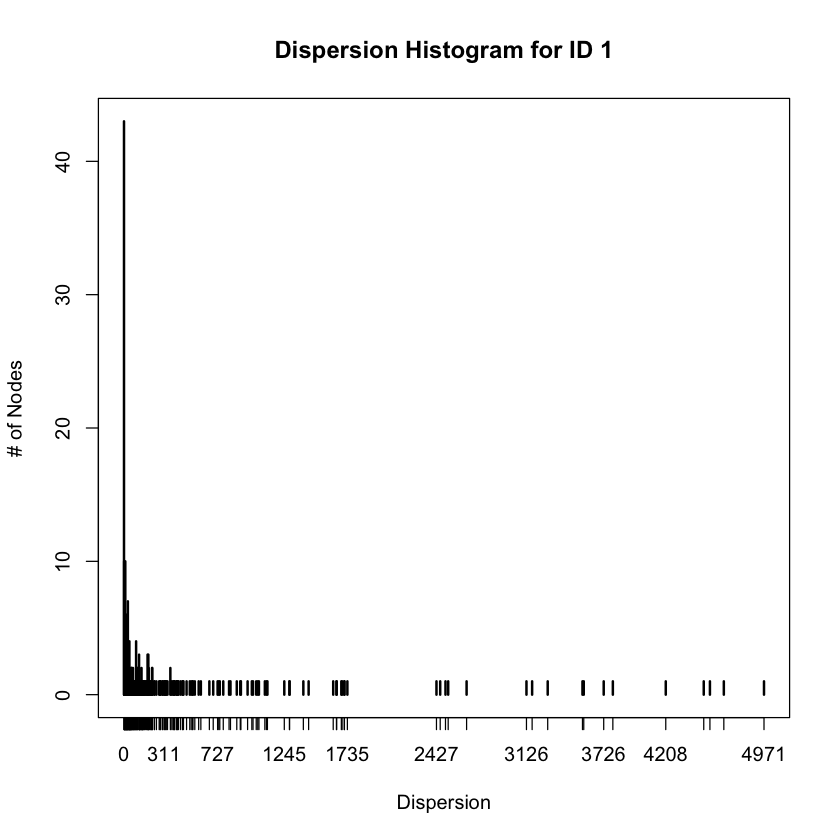

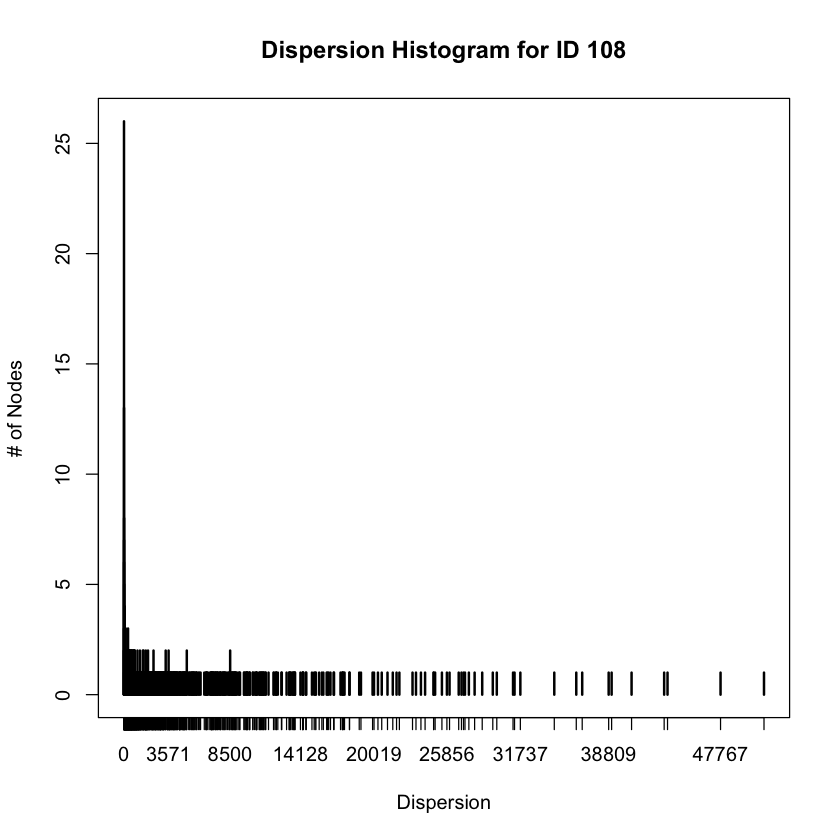

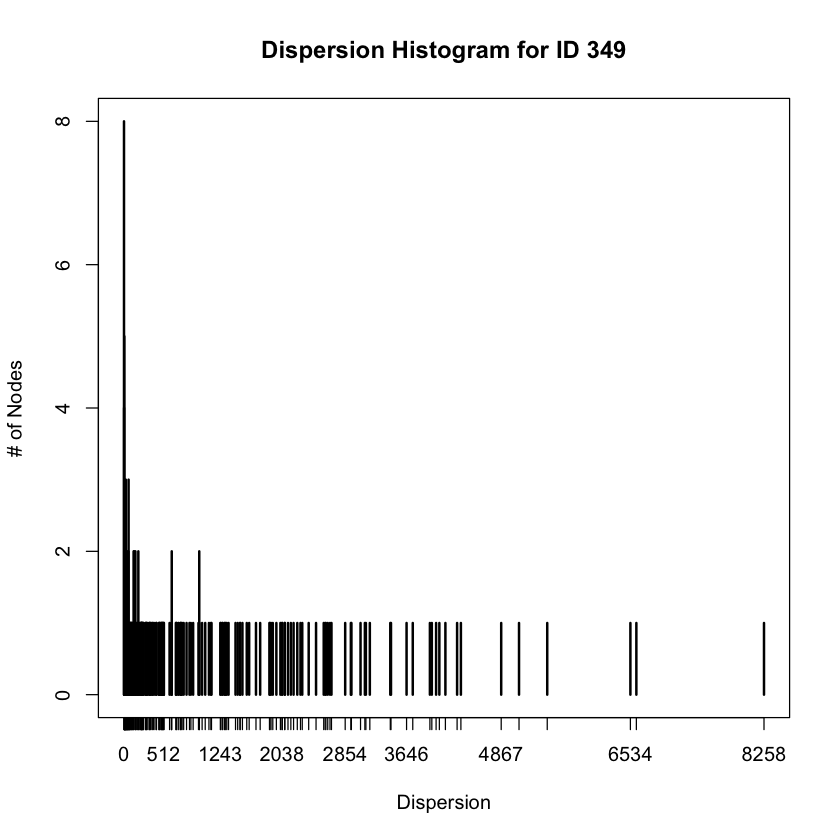

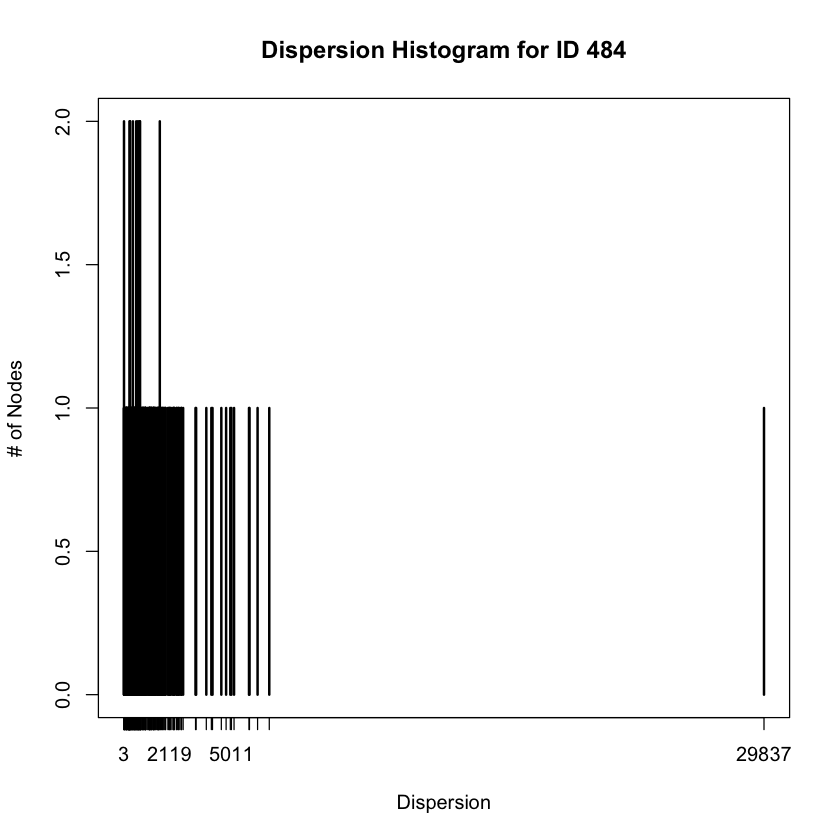

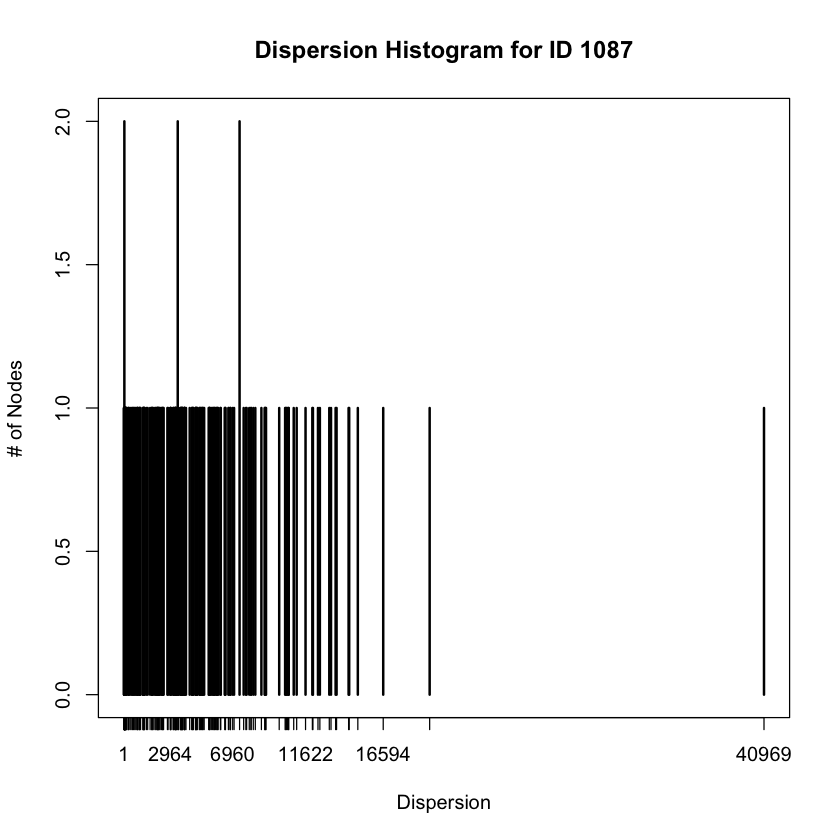

In [363]:
for (i in 1:length(dispersions)) {
    plot(table(dispersions[i]), xlab='Dispersion', ylab='# of Nodes', main=paste0('Dispersion Histogram for ID ', strtoi(nodes[i])+1) )
}

### QUESTION 13: For each of the core node’s personalized network, plot the community structure of the personalized network using colors and highlight the node with maximum dispersion. Also, highlight the edges incident to this node. To detect the community structure, use Fast-Greedy algorithm. In this question, you will have 5 plots.

In [385]:


node_max_dispersion = neighbor_v$name[which(dispersion == max(dispersion))]
    nmd_idx = match(node_max_dispersion, V(pg)$name)
print(nmd_idx)

[1] 57


### QUESTION 14: Repeat Question 13, but now highlight the node with maximum embeddedness and the node with maximum dispersion/embeddedness (excluding the nodes having zero embeddedness if there are any). Also, highlight the edges incident to these nodes. Report the id of those nodes.



Personalized network of node 1 :
Node with max dispersion: 56 +1
Node with max embeddedness: 56 +1
Node with max quotient: 25 +1

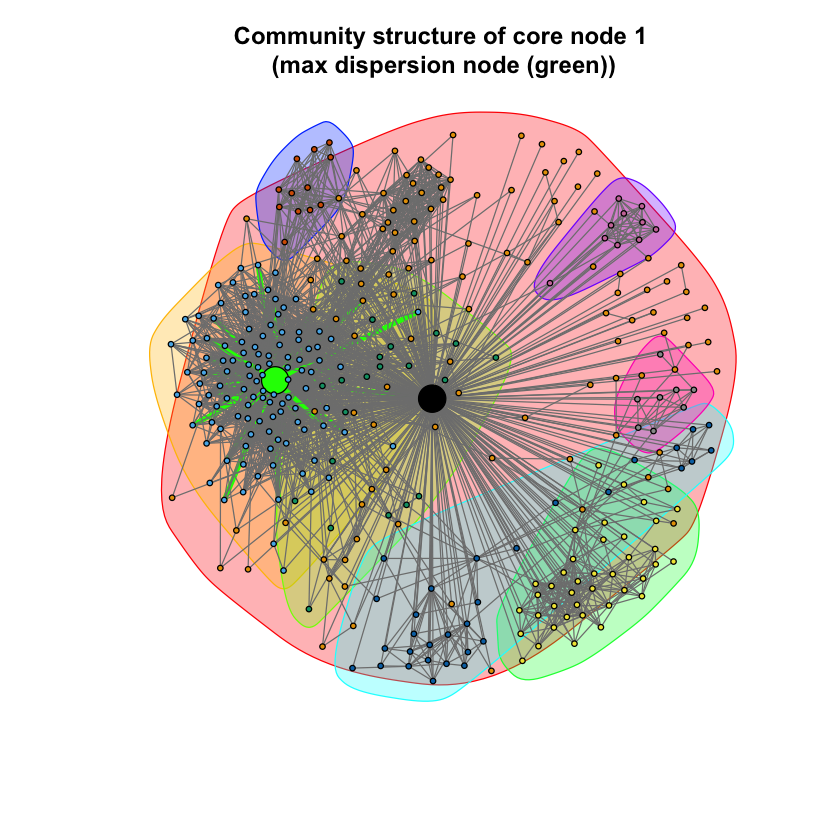



Personalized network of node 108 :
Node with max dispersion: 1888 +1
Node with max embeddedness: 1888 +1
Node with max quotient: 1888 +1

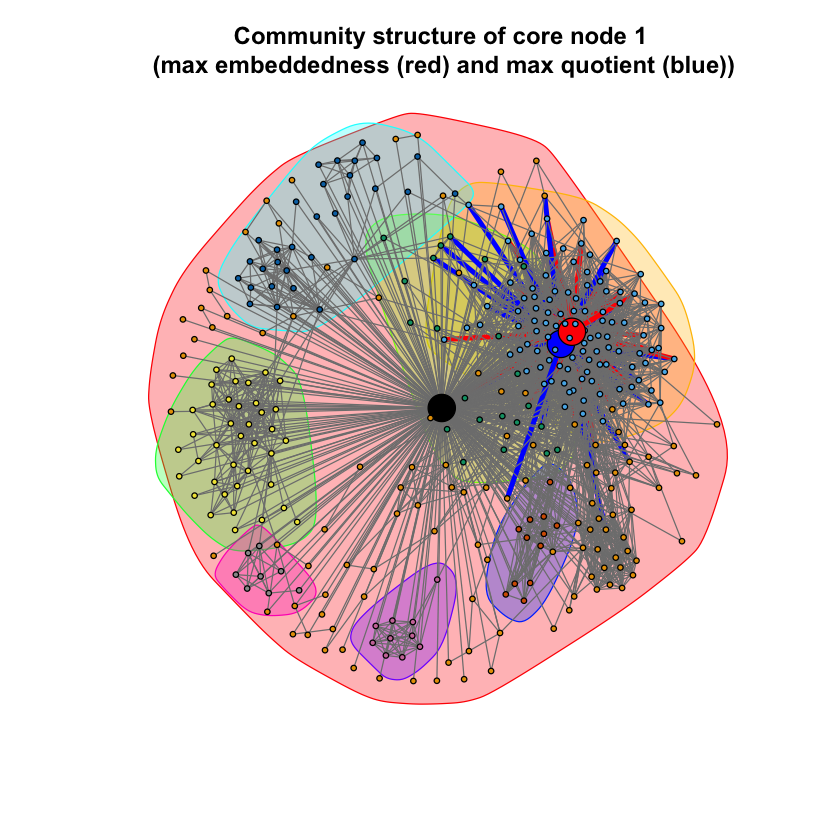

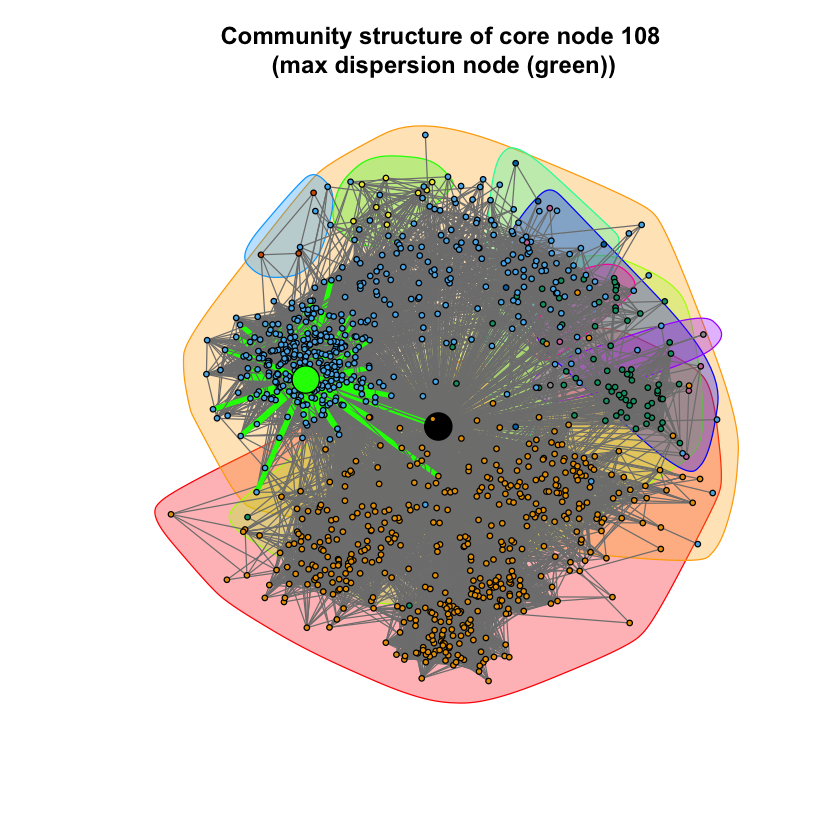



Personalized network of node 349 :
Node with max dispersion: 376 +1
Node with max embeddedness: 376 +1
Node with max quotient: 376 +1

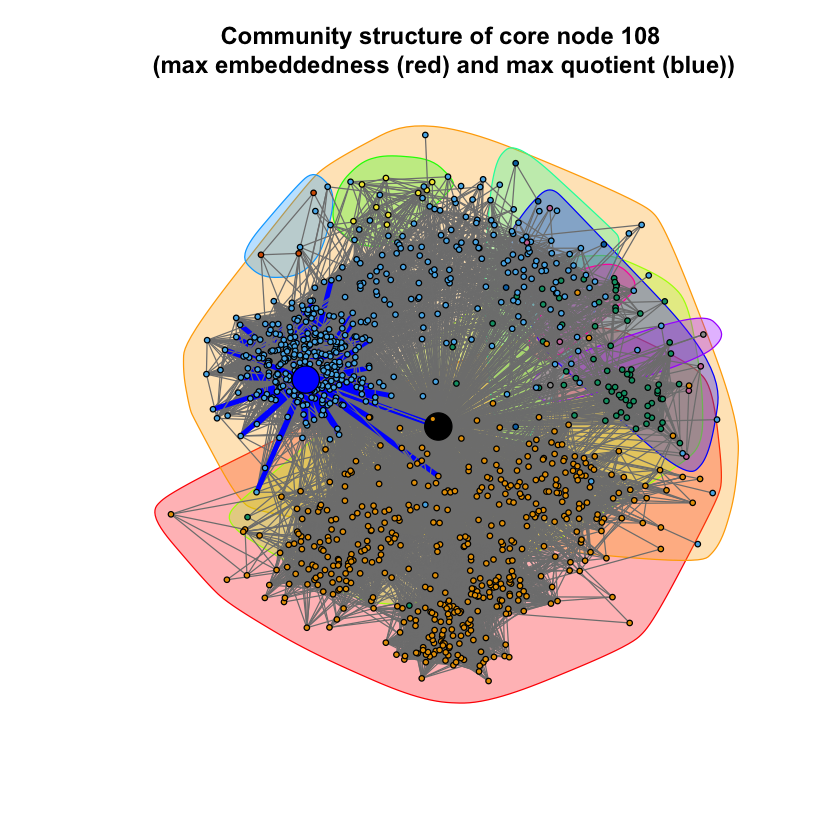

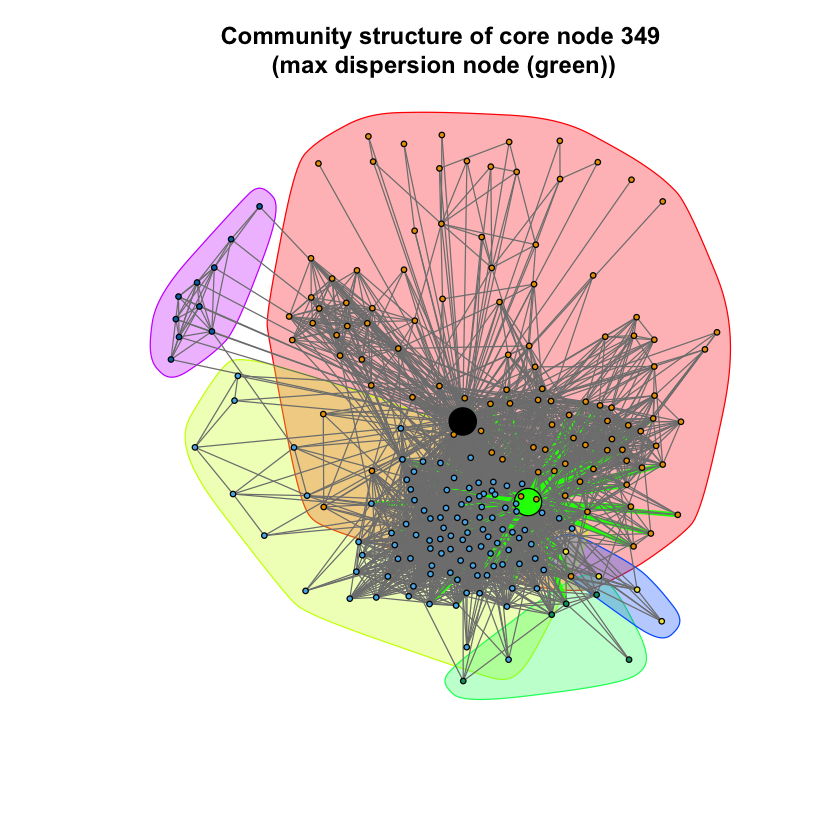



Personalized network of node 484 :
Node with max dispersion: 107 +1
Node with max embeddedness: 107 +1
Node with max quotient: 107 +1

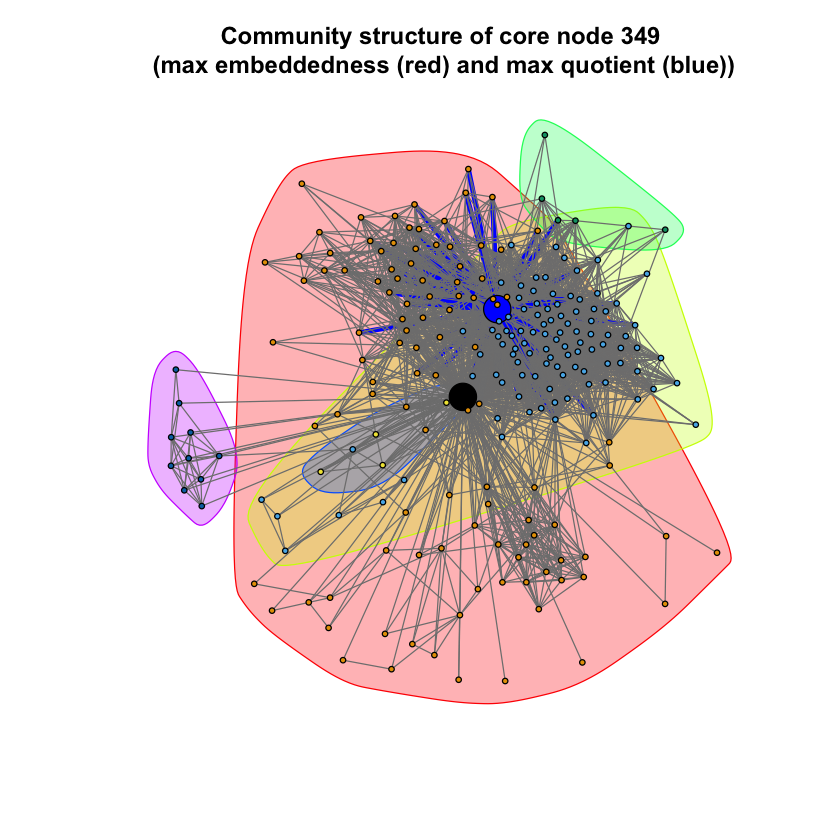

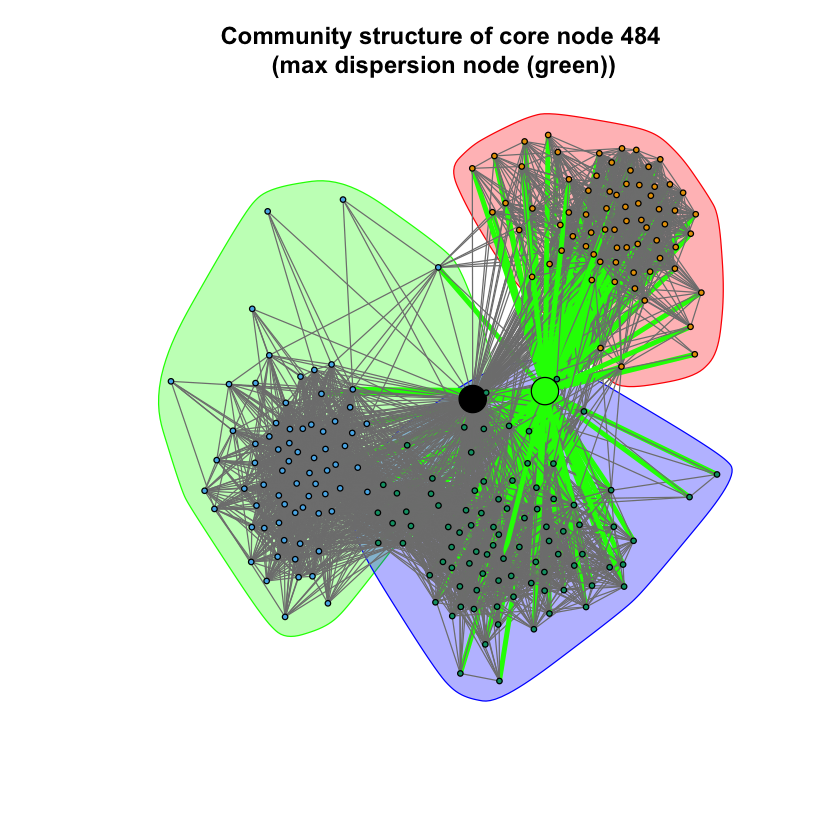



Personalized network of node 1087 :
Node with max dispersion: 107 +1
Node with max embeddedness: 107 +1
Node with max quotient: 107 +1

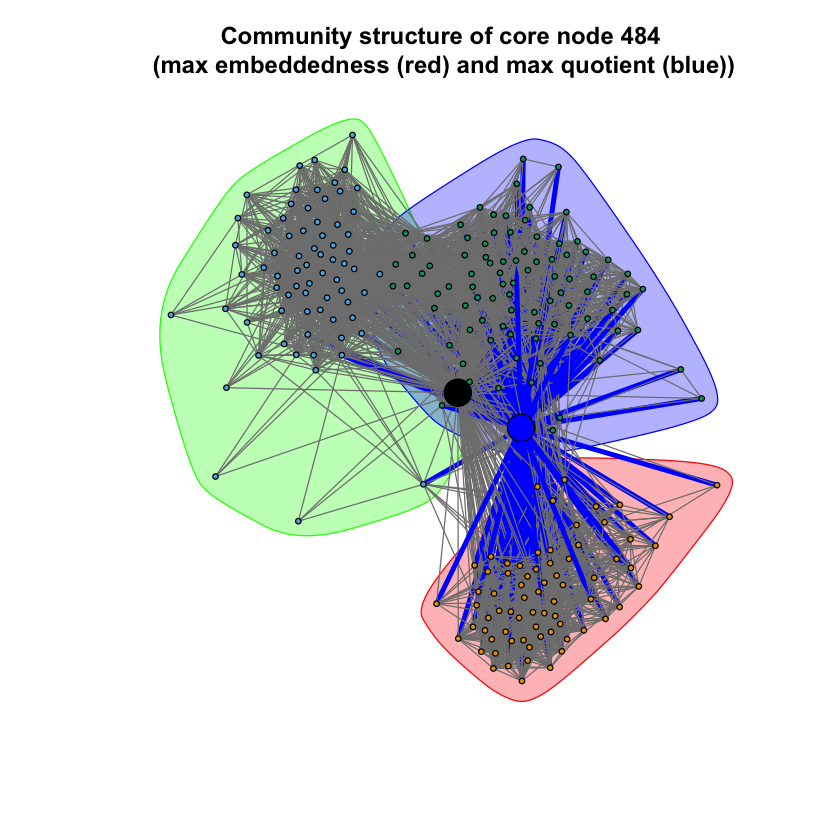

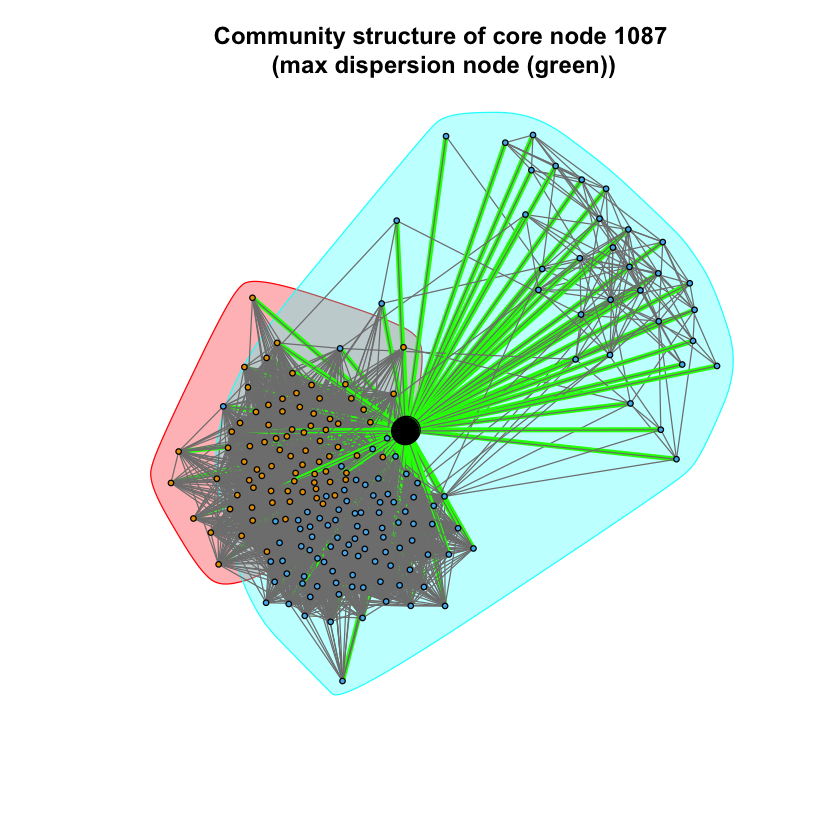

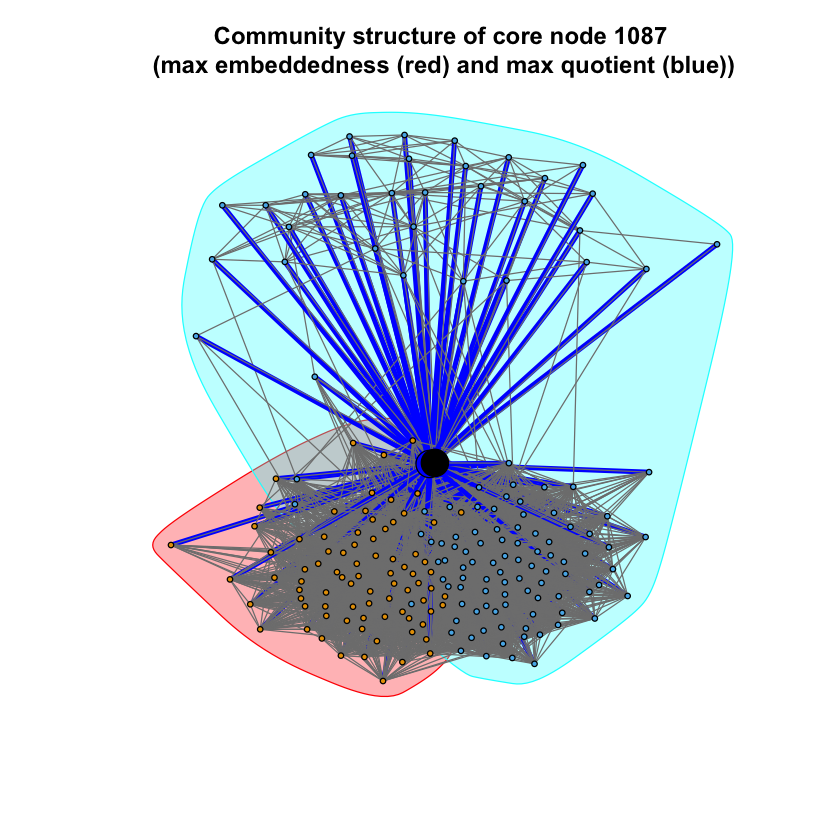

In [390]:
# Highlight nodes
for (i in 1:nodes_len)
{
    # Current personalized network
    pg = personal_list[[i]]
    core_idx = match(nodes[i], V(pg)$name) # Get core node idx in the personalized network
    
    # Dispersion and embeddedness
    dispersion = dispersions[[i]]
    neighbor_v = neighbors(pg, nodes[i])
    v_len = length(neighbor_v)
    embeddedness = c(1:v_len)
    for (j in 1:v_len){
        embeddedness[j] = degree(pg, neighbor_v[j]$name) - 1
    }
    
    node_max_dispersion = neighbor_v$name[which(dispersion == max(dispersion))]
    nmd_idx = match(node_max_dispersion, V(pg)$name)
    node_max_embeddedness = neighbor_v$name[which(embeddedness == max(embeddedness))]
    nme_idx = match(node_max_embeddedness, V(pg)$name)
    quotient = dispersion / embeddedness
    quotient[is.nan(quotient)] = 1 # Define 0/0 = 0
    node_max_quotient = neighbor_v$name[which(quotient == max(quotient))]
    nmq_idx = match(node_max_quotient, V(pg)$name)
    
    cat("\n\nPersonalized network of node", strtoi(nodes[i])+1, ":")
    cat("\nNode with max dispersion:", node_max_dispersion, "+1")
    cat("\nNode with max embeddedness:", node_max_embeddedness, "+1")
    cat("\nNode with max quotient:", node_max_quotient, "+1")
    
    # Fast-Greedy
    fast_greedy_community = fastgreedy.community(pg)
    
    # Highlight dispersion
    
    # Plot setting
    colors = fast_greedy_community$membership
    colors[nmd_idx] = "green"
    colors[core_idx] = "black"
    sizes = rep(2, vcount(pg))
    sizes[nmd_idx] = 10
    sizes[core_idx] = 10
    e_colors = rep("grey50", ecount(pg))
    e_width = rep(1, ecount(pg))
    
    for (k in nmd_idx) # In case of multiple max nodes
    {
        e_colors[which(get.edgelist(pg, name=FALSE)[,1] == k | 
                         get.edgelist(pg, name=FALSE)[,2] == k)] = "green"
        e_width[which(get.edgelist(pg, name = FALSE)[,1] == k |  
                     get.edgelist(pg, name = FALSE)[,2] == k)] = 4
    }

    # Plot community
    plot(fast_greedy_community, pg, vertex.size=sizes, vertex.label=NA, 
         col=colors, edge.color=e_colors, edge.width=e_width, layout=layout.fruchterman.reingold, 
         main=paste("Community structure of core node", strtoi(nodes[i])+1, "\n(max dispersion node (green))"))
    
    # Highlight embeddedness and quotient
    
    # Plot setting
    colors = fast_greedy_community$membership
    colors[nme_idx] = "red"
    colors[nmq_idx] = "blue"
    colors[core_idx] = "black"
    
    sizes = rep(2, vcount(pg))
    sizes[nme_idx] = 10
    sizes[nmq_idx] = 10
    sizes[core_idx] = 10
    
    e_color = rep("grey50", ecount(pg))
    e_width = rep(1, ecount(pg))
    
    for (k in nme_idx) # In case of multiple max nodes
    {
        e_color[which(get.edgelist(pg, name=FALSE)[,1] == k | 
                         get.edgelist(pg, name=FALSE)[,2] == k)] = "red"
        e_width[which(get.edgelist(pg, name = FALSE)[,1] == k |  
                     get.edgelist(pg, name = FALSE)[,2] == k)] = 4
    }
    
    for (k in nmq_idx) # In case of multiple max nodes
    {
        e_color[which(get.edgelist(pg, name=FALSE)[,1] == k | 
                         get.edgelist(pg, name=FALSE)[,2] == k)] = "blue"
        e_width[which(get.edgelist(pg, name = FALSE)[,1] == k |  
                     get.edgelist(pg, name = FALSE)[,2] == k)] = 4
    }

    # Plot community
    plot(fast_greedy_community, pg, vertex.size=sizes, vertex.label=NA, 
         col=colors, edge.color=e_color, edge.width=e_width, layout=layout.fruchterman.reingold, 
         main=paste("Community structure of core node", strtoi(nodes[i])+1, 
                    "\n(max embeddedness (red) and max quotient (blue))"))
}

### QUESTION 15: Use the plots from Question 13 and 14 to explain the characteristics of a node revealed by each of this measure.

## Friend recommendation in personalized networks
Having defined the friend recommendation procedure, we can now apply it to the personalized network of node ID 415.

So when using ‘ncol’ format, just remember to use name all the time, and subtract 1 from the given ids in the specs when use them as names.

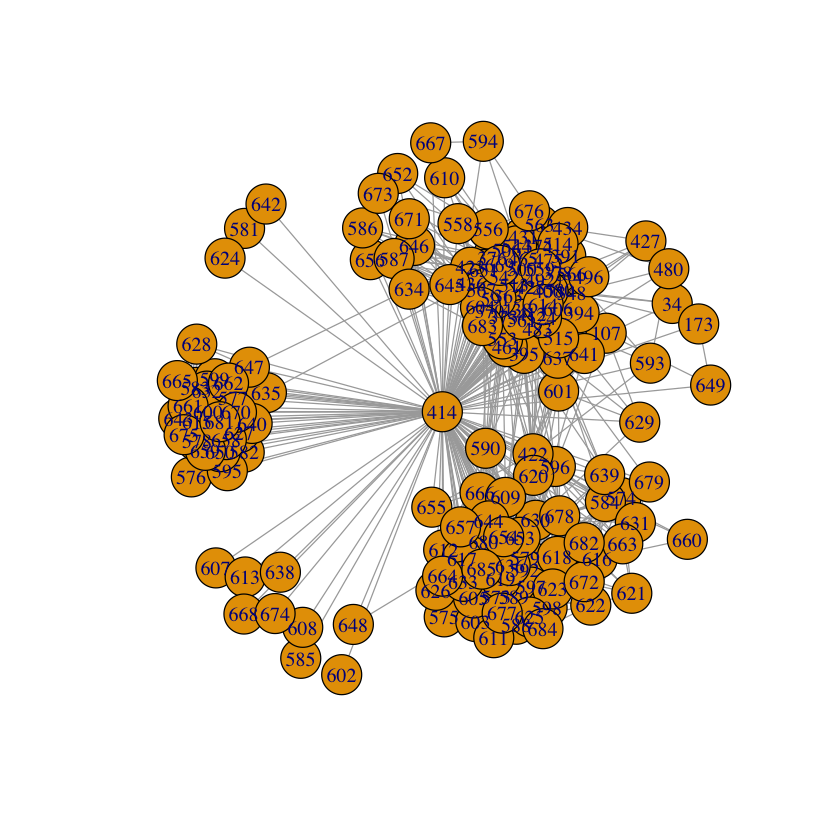

In [248]:
g <- make_ego_graph(facebook_graph, order = 1, "414")[[1]]
dd = degree_distribution(g) * vcount(g)
plot(g)

### QUESTION 16: What is |Nr|, i.e. the length of the list Nr?
We create this list by picking all nodes with degree 24.

In [249]:
dd[25]

[1] 11

In [250]:
common_neighbors <- function(graph, node_i, node_j) {
   length(intersect(neighbors(graph, node_i),neighbors(graph, node_j)))
}

In [251]:
jaccard <- function(graph, node_i, node_j) {
#     print(paste0(node_i, " ", node_j))
   similarity(graph, vids=c(node_i, node_j), method = "jaccard")[2]
}

In [252]:
jaccard1 <- function(graph, nodes) {
   similarity(graph, vids=nodes, method = "jaccard")
}

In [295]:
adamic.adar <- function(graph, node_i, node_j) {
#     print(similarity(graph, vids=c(node_i, node_j), method = "invlogweighted"))
#     print(similarity(graph, vids=c(node_i, node_j), method = "invlogweighted")[2])
#     print(sum(similarity(graph, vids=c(node_i, node_j), method = "invlogweighted")))
    similarity(g, vids=node_i, method = "invlogweighted")[which(V(g)$name==node_j)]
}

In [254]:
adamic.adar1 <- function(graph, node_i, node_j) {
   similarity(graph, vids=nodes, method = "invlogweighted")
}

In [255]:
# common_neighbors(subgraph2, 1, 42)

In [256]:
# similarity(subgraph1, vids=c(1, 3), method = "jaccard")[2]

In [257]:
# jaccard(g, 42, 138)

In [258]:
# adamic.adar(subgraph1, 1, 3)

In [259]:
(degree(g))["496"]

496 
 24

In [260]:
n_list = which(cbind(degree(g))==24)

In [261]:
n_list

[1]  42  85 100 109 112 120 131 140 141 143 144

In [309]:
V(g)[n_list]$name

[1] "496" "578" "600" "615" "618" "627" "643" "658" "659" "661" "662"

In [263]:
incident(g, "496")

+ 24/1857 edges from fe237fd (vertex names):
 [1] 348--496 414--496 376--496 475--496 483--496 566--496 580--496 637--496
 [9] 641--496 427--496 373--496 374--496 378--496 412--496 434--496 436--496
[17] 438--496 496--506 496--513 496--514 496--515 496--553 496--591 496--669

In [264]:
neighbors(g, "496")

+ 24/160 vertices, named, from fe237fd:
 [1] 348 414 376 475 483 566 580 637 641 427 373 374 378 412 434 436 438 506 513
[20] 514 515 553 591 669

### QUESTION 17: Compute the average accuracy of the friend recommendation algorithm that uses:
• Common Neighbors measure

In [296]:
iter = 10
n_list = V(g)[which(c(degree(g))==24)]
list_len = length(n_list)

cn_acc = c(1:iter*list_len)
j_acc = c(1:iter*list_len)
aa_acc = c(1:iter*list_len)


for (k in 1:iter) {
    for (i in 1:list_len){
        neighbor_v = neighbors(g, n_list[i]$name)
        neighbor_e = incident(g, n_list[i]$name)

        rand_gen = sample(c(0:3),length(neighbor_v), replace=TRUE)
        edges_remove = which(rand_gen==0)
        while (length(edges_remove)==0)
        {
            rand_gen = sample(c(0:3),length(neighbor_v), replace=TRUE)
            edges_remove = which(rand_gen==0)
        }
        

        ri_len = length(edges_remove)
        ri = neighbor_v[edges_remove]
        pruned_g = g - neighbor_e[edges_remove]
        
        leftover_v = neighbor_v[-edges_remove]
        leftover_e = neighbor_e[-edges_remove]
        cand = V(g)[setdiff(V(g), leftover_v)]
        cand_len = length(cand)
    #     print(leftover_v)
    #     print(cand)
    #     print(jaccard1(g, cand))
        cn_list = c(1:cand_len)
        j_list = c(1:cand_len)
        aa_list = c(1:cand_len)
        for (j in 1:cand_len){
            cn_list[j] = common_neighbors(pruned_g, n_list[i]$name, cand[j]$name)
            j_list[j] = jaccard(pruned_g, n_list[i]$name, cand[j]$name)
            aa_list[j] = adamic.adar(pruned_g, n_list[i]$name, cand[j]$name)
    #         print(paste0("CN: ", common_neighbors(pruned_g, n_list[i], cand[j])))
    #         print(paste0("J: ", jaccard(pruned_g, n_list[i], cand[j])))
    #         print(paste0("AA: ", adamic.adar(pruned_g, n_list[i], cand[j])))

        }
    cn_pi = cand[tail(order(cn_list, decreasing=FALSE), n=ri_len)]
    j_pi = cand[tail(order(j_list, decreasing=FALSE), n=ri_len)]
    aa_pi = cand[tail(order(aa_list, decreasing=FALSE), n=ri_len)]

#     print(ri)
#     print(aa_pi)
#     print(length(intersect(aa_pi, ri)))
#     print(ri_len)
    cn_acc[(k-1)*list_len+i] = length(intersect(cn_pi, ri))/ri_len
    j_acc[(k-1)*list_len+i] = length(intersect(j_pi, ri))/ri_len
    aa_acc[(k-1)*list_len+i] = length(intersect(aa_pi, ri))/ri_len
    }
}


In [297]:
mean(cn_acc)

[1] 0.6842565

In [298]:
mean(j_acc)

[1] 0.6667096

In [299]:
mean(aa_acc)

[1] 0.8156962

In [308]:
length(cn_acc)

for (i in 1:11){
    print(mean(cn_acc[seq.int(i, length(cn_acc), 11)]))
}

[1] 110

[1] 0.2069048
[1] 0.8379762
[1] 0.749881
[1] 0.6659524
[1] 0.3665873
[1] 0.8176984
[1] 0.6904762
[1] 0.7911075
[1] 0.8244841
[1] 0.7905556
[1] 0.7851984


In [310]:
length(j_acc)
for (i in 1:11){
    print(mean(j_acc[seq.int(i, length(j_acc), 11)]))
}

[1] 110

[1] 0.09440476
[1] 0.8379762
[1] 0.729881
[1] 0.6659524
[1] 0.4254762
[1] 0.8176984
[1] 0.6779762
[1] 0.7799964
[1] 0.8119841
[1] 0.7683333
[1] 0.724127


In [311]:
length(aa_acc)
for (i in 1:11){
    print(mean(aa_acc[seq.int(i, length(aa_acc), 11)]))
}

[1] 110

[1] 0.2269048
[1] 1
[1] 0.8665476
[1] 0.7954762
[1] 0.417381
[1] 1
[1] 0.8821429
[1] 1
[1] 1
[1] 0.8702778
[1] 0.9139286


In [174]:
c('a', 'b')

[1] "a" "b"

In [294]:
similarity(g, vids='348', method = "invlogweighted")[which(V(g)$name=='414')]

[1] 14.2257

In [289]:
which(V(g)$name==348)

[1] 4

In [286]:
V(g)

+ 160/160 vertices, named, from fe237fd:
  [1] 34  107 173 348 414 428 363 376 475 483 563 566 580 596 601 606 629 637
 [19] 641 649 651 427 370 373 374 378 391 394 395 400 412 422 423 431 434 436
 [37] 438 461 465 480 492 496 500 506 513 514 515 524 542 544 553 556 558 559
 [55] 561 567 591 656 669 604 645 646 666 683 587 590 614 634 680 586 610 652
 [73] 673 676 620 574 630 678 593 609 573 575 576 577 578 579 581 582 583 584
 [91] 585 588 589 592 594 595 597 598 599 600 602 603 605 607 608 611 612 613
[109] 615 616 617 618 619 621 622 623 624 625 626 627 628 631 632 633 635 636
[127] 638 639 640 642 643 644 647 648 650 653 654 655 657 658 659 660 661 662
[145] 663 664 665 667 668 670 671 672 674 675 677 679 681 682 684 685